## Imports

In [14]:
import librosa
import numpy as np
import os
import sys

from matplotlib import pyplot as plt

from pyroomasync.settings import SPEED_OF_SOUND
from pyroomasync.room import ConnectedShoeBox
from pyroomasync.simulator import simulate
from scipy.signal.signaltools import correlate, correlation_lags

sys.path.append("..")
import tdoa
from tdoa.tdoa import compute_correlations
from tdoa.math import compute_distance

from tdoa.visualization import get_2d_room_plot_axis

from datasets.generate_random_configs import generate_random_source_signal

# Increasing room size means lower reverberation 
ROOM_DIM = [10, 10, 3]
SOURCE_LOCATION = [5, 5, 1]
MIC_LOCATIONS = [[3, 3, 1], [6, 6.5, 1]]


## Simulate for two input signals

Distances: 2.83m, 1.80m. DOA = 1.03m TDOA = 2.99ms
Distances: 2.83m, 1.80m. DOA = 1.03m TDOA = 2.99ms


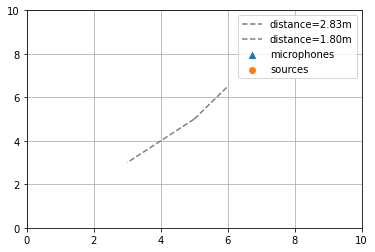

In [20]:
def simulate_room(input_signal, fs):

    dists = [
        compute_distance(SOURCE_LOCATION, mic_loc)
        for mic_loc in MIC_LOCATIONS
    ]
    
    doa = dists[0] - dists[1]
    tdoa_in_ms = 1000*doa/SPEED_OF_SOUND
    print("Distances: {0:.2f}m, {1:.2f}m. DOA = {2:.2f}m TDOA = {3:.2f}ms".format(
            dists[0], dists[1], doa, tdoa_in_ms))
    room = ConnectedShoeBox(ROOM_DIM, fs=fs)
    room.add_source(SOURCE_LOCATION, input_signal)
    room.add_microphone_array(MIC_LOCATIONS)

    simulation_results = simulate(room)
    return simulation_results, room


input_signal, fs = librosa.load("../tests/fixtures/p225_001.wav")
random_input_signal, _ = generate_random_source_signal(fs, input_signal.shape[0]/fs, random_gain=False)

simulated_microphone_signals, room = simulate_room(input_signal, fs)
simulated_rand_microphone_signals, _ = simulate_room(random_input_signal, fs)

get_2d_room_plot_axis(room)
plt.show()

In [21]:
def cross_correlation(x1, x2, fs, abs=True):
    
    # Normalize signals for a normalized correlation
    # https://github.com/numpy/numpy/issues/2310
    x1 = (x1 - np.mean(x1)) / (np.std(x1) * len(x1))
    x2 = (x2 - np.mean(x2)) / (np.std(x2) * len(x2))
    
    cc = correlate(x1, x2, mode="same")
    lag_indexes = correlation_lags(x1.shape[0], x2.shape[0], mode="same")

    if abs:
        cc = np.abs(cc)
    return cc, lag_indexes/fs

def auto_correlation(x, fs):
    return cross_correlation(x, x, fs)


autocorrelation, lag_indexes = auto_correlation(input_signal, fs)

rand_autocorrelation, rand_lag_indexes = auto_correlation(random_input_signal, fs)


## Speech and noise autocorrelation

Signal size: 45237
Autocorrelation size: 45237
Lags size: 45237


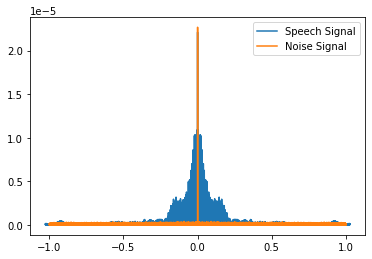

In [22]:
# print("Signal size:", input_signal.shape[0])
# print("Autocorrelation size:", autocorrelation.shape[0])
# print("Lags size:", lag_indexes.shape[0])
# plt.plot(lag_indexes, autocorrelation, label="Speech Signal")
# plt.plot(rand_lag_indexes, rand_autocorrelation, label="Noise Signal")
# plt.legend()
# plt.show()

## Output signal autocorrelation comparison

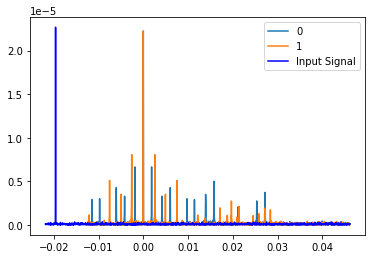

In [25]:
def plot_output_autocorrelation(input_signal, simulated_microphone_signals):
    for i, signal in enumerate(simulated_microphone_signals):
        autocorrelation, lag_indexes = auto_correlation(signal, fs)
        plt.plot(lag_indexes[22200:23500], autocorrelation[22200:23500], label=i) # [22500:23500]
    
    plt.plot(rand_lag_indexes[22000:23500], rand_autocorrelation[22000:23500], label="Input Signal", color="b")
    plt.legend()
    plt.show()
    

plot_output_autocorrelation(random_input_signal, simulated_rand_microphone_signals)

In [24]:
from ipywidgets import interact_manual, FloatSlider

cc, lag_indexes = cross_correlation(simulated_microphone_signals[0],
                                    simulated_microphone_signals[1],
                                    fs)

rand_cc, rand_lag_indexes = cross_correlation(simulated_rand_microphone_signals[0],
                                              simulated_rand_microphone_signals[1],
                                              fs)

tdoa_rand = rand_lag_indexes[np.argmax(np.abs(rand_cc))]
tdoa = lag_indexes[np.argmax(cc)]
print("TDOA Noise: {0:.2f}ms".format(tdoa_rand*1000))
print("TDOA Speech: {0:.2f}ms".format(tdoa*1000))

#plt.plot(lag_indexes_rand, cc_rand)
#plt.plot(lag_indexes, cc)


def plot_interval(x, y, fs):
    max_end_secs = (x.shape[0]/fs)/2
    min_start_secs = -max_end_secs
    
    def plot_func(start_secs=min_start_secs, end_secs=max_end_secs):
        start_secs += max_end_secs
        end_secs += max_end_secs
        start = int(start_secs*fs)
        end = int(end_secs*fs)
        x_interval = x[start:end]
        y_interval = y[start:end]
        
        plt.plot(x_interval, y_interval)

    start_slider = FloatSlider(min=min_start_secs, max=max_end_secs, step=0.03, value=min_start_secs)
    end_slider = FloatSlider(min=min_start_secs, max=max_end_secs, step=0.03, value=max_end_secs)

    interact_manual(plot_func,
             start_secs=start_slider,
             end_secs=end_slider)

plot_interval(lag_indexes, cc, fs)

TDOA Noise: 2.99ms
TDOA Speech: 3.81ms


interactive(children=(FloatSlider(value=-1.0453514739229024, description='start_secs', max=1.0453514739229024,…